# Recommender System Testing

The focus of this notebook is to test various code snippest, processing, subcomponents and integration of subcomponents for the recommender system

## Data Processing

External databases are initially used to test and train the recommender system so no actual pre-processing is required for that but when an online version is created and data is logged this will need to be processed and stored. For now the csv ratings file will be loaded and mappings will be created from user and movie ids to indexes. A sparse matrix will then be created to make indexing much easier, for this project double indexing will be done as it is more efficient than having a full sparse matrix.

In [1]:
import csv
import time
import os
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import optuna

train_ratio = 0.8
optuna_optimisation = False
# optuna_optimisation = True

external_data_path = "../data/external/"
image_path = "images/"

In [2]:
folder_name = external_data_path + "ml-latest-small"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []

test_count = 0
train_count = 0
start_time = time.time()
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_test.append([])
                user_ratings_train.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([]) 
                movie_ratings_test.append([])

            rand = random.random()
            if rand < 1:
                user_ratings_train[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_train[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                train_count += 1
            else:
                user_ratings_test[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_test[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.time()
print("Finished")
print("Time taken:", end_time - start_time, "seconds")

print("Train Count:", train_count)
print("Test Count:", test_count)

Finished
Time taken: 0.19140195846557617 seconds
Train Count: 100836
Test Count: 0


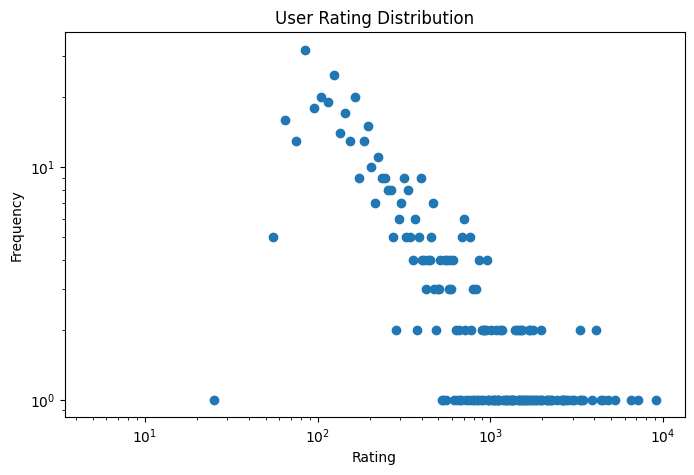

In [3]:
user_total_ratings = []

for row in user_ratings_train:
    user_sum = sum([rating for _, rating in row])
    user_total_ratings.append(user_sum)

all_user_ratings = [rating for rating in user_total_ratings]
user_rating_counts = Counter(all_user_ratings)
user_ratings = np.array(sorted(user_rating_counts.keys()))
user_frequencies = np.array([user_rating_counts[r] for r in user_ratings])

user_bin_edges = np.arange(0, max(user_total_ratings) + 10, 10)
user_frequencies, user_bins = np.histogram(user_total_ratings, bins=user_bin_edges)
user_bin_centers = 0.5 * (user_bins[1:] + user_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(user_bin_centers, user_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('User Rating Distribution')
plt.savefig(image_path + 'user_rating_distribution.svg')
plt.show()

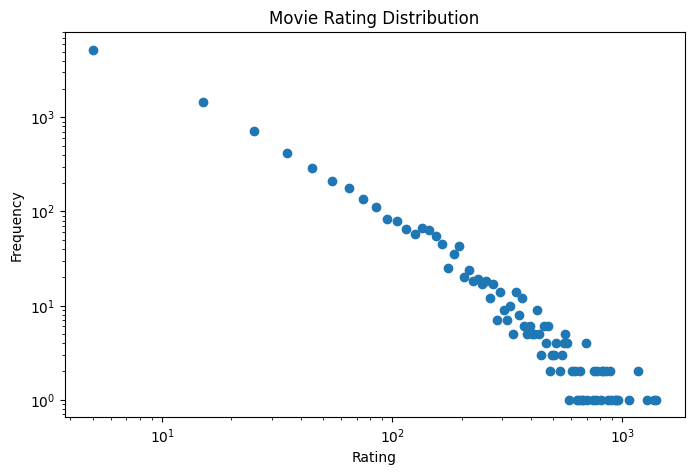

In [4]:
movie_total_ratings = []

for row in movie_ratings_train:
    movie_sum = sum([rating for _, rating in row])
    movie_total_ratings.append(movie_sum)

all_movie_ratings = [rating for rating in movie_total_ratings]
movie_rating_counts = Counter(all_movie_ratings)
movie_ratings = np.array(sorted(movie_rating_counts.keys()))
movie_frequencies = np.array([movie_rating_counts[r] for r in movie_ratings])

movie_bin_edges = np.arange(0, max(movie_total_ratings) + 10, 10)
movie_frequencies, movie_bins = np.histogram(movie_total_ratings, bins=movie_bin_edges)
movie_bin_centers = 0.5 * (movie_bins[1:] + movie_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(movie_bin_centers, movie_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Movie Rating Distribution')
plt.savefig(image_path + 'movie_rating_distribution.svg')
plt.show()

## Bias Model 

In [5]:
# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []

test_count = 0
train_count = 0
start_time = time.time()
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_test.append([])
                user_ratings_train.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([]) 
                movie_ratings_test.append([])

            rand = random.random()
            if rand < train_ratio:
                user_ratings_train[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_train[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                train_count += 1
            else:
                user_ratings_test[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_test[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.time()
print("Finished")
print("Time taken:", end_time - start_time, "seconds")

print("Train Count:", train_count)
print("Test Count:", test_count)

Finished
Time taken: 0.15776968002319336 seconds
Train Count: 80467
Test Count: 20369


In [6]:
# Hyperparameters
lam = 0.1
gamma = 0.1
num_epochs = 100

# Configure Biases
user_biases = np.zeros(len(user_ratings_train))
item_biases = np.zeros(len(movie_ratings_train))
training_loss = []
training_RMSE = []
testing_RMSE = []

# Estimate biases with loss function
for epoch in range(num_epochs):
    for u in range(len(user_ratings_train)):
        bias = 0
        counter = 0
        for movie_idx, rating in user_ratings_train[u]:
            bias += (rating - item_biases[movie_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        user_biases[u] = bias

    for m in range(len(movie_ratings_train)):
        bias = 0
        counter = 0
        for user_idx, rating in movie_ratings_train[m]:
            bias += (rating - user_biases[user_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        item_biases[m] = bias

    train_loss = 0
    count = 0
    train_error = 0
    for u, user_ratings in enumerate(user_ratings_train):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            train_error += (rating - pred) * (rating - pred)
            count += 1 
    train_rmse = np.sqrt(train_error / (count + 1e-10))
    train_loss = (lam * (train_error)) + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2)))
    training_loss.append(train_loss)
    training_RMSE.append(train_rmse)

    test_loss = 0
    test_error = 0
    count = 0
    for u, user_ratings in enumerate(user_ratings_test):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            test_error += (rating - pred) * (rating - pred)
            count += 1
    test_rmse = np.sqrt(test_error / (count + 1e-10))
    testing_RMSE.append(test_rmse)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

Epoch 1/100, Loss: 6205.5636, Train RMSE: 0.8040, Test RMSE: 0.8830
Epoch 2/100, Loss: 6013.0510, Train RMSE: 0.7901, Test RMSE: 0.8713
Epoch 3/100, Loss: 5985.3852, Train RMSE: 0.7890, Test RMSE: 0.8706
Epoch 4/100, Loss: 5968.7905, Train RMSE: 0.7888, Test RMSE: 0.8704
Epoch 5/100, Loss: 5955.2842, Train RMSE: 0.7888, Test RMSE: 0.8703
Epoch 6/100, Loss: 5943.9780, Train RMSE: 0.7887, Test RMSE: 0.8703
Epoch 7/100, Loss: 5934.4858, Train RMSE: 0.7887, Test RMSE: 0.8703
Epoch 8/100, Loss: 5926.5130, Train RMSE: 0.7888, Test RMSE: 0.8704
Epoch 9/100, Loss: 5919.8159, Train RMSE: 0.7888, Test RMSE: 0.8704
Epoch 10/100, Loss: 5914.1904, Train RMSE: 0.7888, Test RMSE: 0.8705
Epoch 11/100, Loss: 5909.4649, Train RMSE: 0.7889, Test RMSE: 0.8706
Epoch 12/100, Loss: 5905.4954, Train RMSE: 0.7889, Test RMSE: 0.8707
Epoch 13/100, Loss: 5902.1610, Train RMSE: 0.7890, Test RMSE: 0.8708
Epoch 14/100, Loss: 5899.3601, Train RMSE: 0.7890, Test RMSE: 0.8710
Epoch 15/100, Loss: 5897.0074, Train RMSE: 

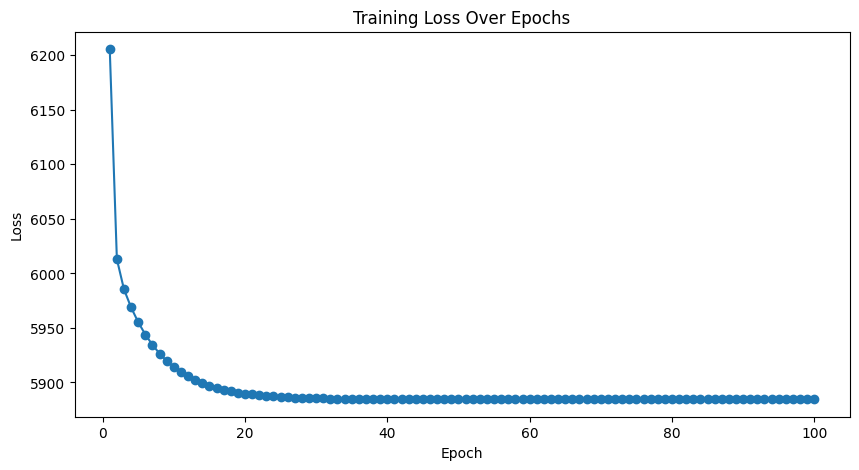

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'bias_trianing_loss.svg')
plt.show()

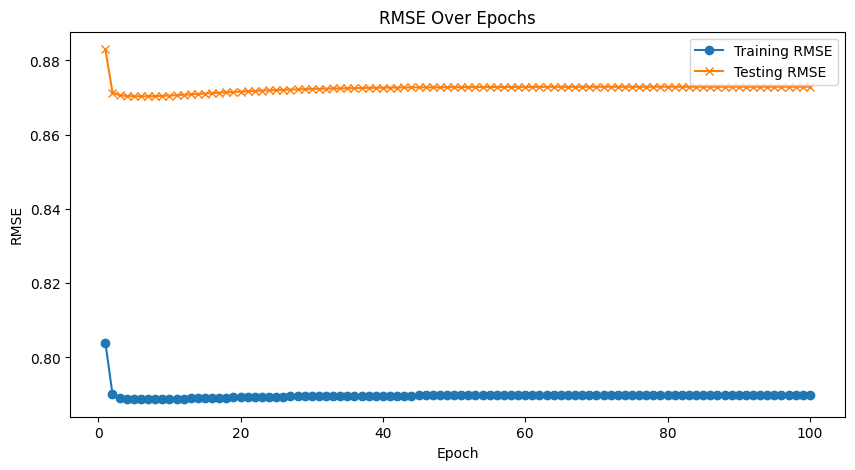

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'bias_rmse.svg')
plt.show()

## Full Model

#### First Version

In [9]:
def training_old(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            bias = 0
            counter = 0
            user = 0
            for movie_idx, rating in user_ratings_train[u]:
                bias += lam * (rating - ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            user_biases[u] = bias
            
            user_term = 0
            user_inverse_term = 0
            for movie_idx, rating in user_ratings_train[u]:
                user_inverse_term += lam * ((item_embeddings[movie_idx].T @ item_embeddings[movie_idx]) + (tau * np.eye(embeddings_dim)))
                user_term += lam * item_embeddings[movie_idx] * (rating - user_biases[u] - item_biases[movie_idx])
            user = np.linalg.solve(user_inverse_term, user_term)
            user_embeddings[u] = user

        for m in range(len(movie_ratings_train)):
            bias = 0
            counter = 0
            for user_idx, rating in movie_ratings_train[m]:
                bias += lam * (rating - ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            item_biases[m] = bias

            item_term = 0
            item_inverse_term = 0
            for user_idx, rating in movie_ratings_train[m]:
                item_inverse_term += lam * ((user_embeddings[user_idx].T @ user_embeddings[user_idx]) + (tau * np.eye(embeddings_dim)))
                item_term += lam * user_embeddings[user_idx] * (rating - user_biases[user_idx] - item_biases[m])
            item = np.linalg.solve(item_inverse_term, item_term)
            item_embeddings[m] = item

        train_loss = 0
        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings.T @ user_embeddings) + np.sum(item_embeddings.T @ item_embeddings)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

#### Optimised Version

In [10]:
def training_optimised(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    tau_identity = tau * np.eye(embeddings_dim)

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            counter = 0
            ratings = np.zeros(len(user_ratings_train[u]))
            pred = np.zeros(len(user_ratings_train[u]))
            for movie_idx, rating in user_ratings_train[u]:
                ratings[counter] = rating
                pred[counter] = ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx])
                counter += 1
            bias = lam * np.sum(ratings - pred)
            user_biases[u] = bias / ((lam * counter) + gamma)
            
            user_inverse_term = np.zeros((embeddings_dim, embeddings_dim))
            user_term = np.zeros(embeddings_dim)
            for movie_idx, rating in user_ratings_train[u]:
                item_vec = item_embeddings[movie_idx]
                user_inverse_term += np.outer(item_vec, item_vec)
                user_term += item_vec * (rating - user_biases[u] - item_biases[movie_idx])
            user_inverse_term = (lam * user_inverse_term) + tau_identity
            user_embeddings[u] = np.linalg.solve(user_inverse_term, lam * user_term)

        for m in range(len(movie_ratings_train)):
            counter = 0
            ratings = np.zeros(len(movie_ratings_train[m]))
            pred = np.zeros(len(movie_ratings_train[m]))
            for user_idx, rating in movie_ratings_train[m]:
                ratings[counter] = rating
                pred[counter] = ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx])
                counter += 1
            bias = lam * np.sum(ratings - pred)
            item_biases[m] = bias / ((lam * counter) + gamma)

            item_inverse_term = np.zeros((embeddings_dim, embeddings_dim))
            item_term = np.zeros(embeddings_dim)
            for user_idx, rating in movie_ratings_train[m]:
                user_vec = user_embeddings[user_idx]
                item_inverse_term += np.outer(user_vec, user_vec)
                item_term += user_vec * (rating - user_biases[user_idx] - item_biases[m])
            item_inverse_term = (lam * item_inverse_term) +  tau_identity
            item = np.linalg.solve(item_inverse_term, lam * item_term)
            item_embeddings[m] = item

        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u] @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings**2) + np.sum(item_embeddings**2)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u] @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

In [11]:
# Hyperparameters
lam = 1
gamma = 1
tau = 10
num_epochs = 20
embeddings_dim = 10
const = 1

scale = const/np.sqrt(embeddings_dim)
training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings = training_optimised(
    num_epochs=num_epochs,
    lam=lam,
    gamma=gamma,
    tau=tau,
    embeddings_dim=embeddings_dim,
    scale=scale)

Epoch 1/20, Loss: 62139.4199, Train RMSE: 0.7896, Test RMSE: 0.8831
Epoch 2/20, Loss: 57423.5695, Train RMSE: 0.7296, Test RMSE: 0.8684
Epoch 3/20, Loss: 54408.7876, Train RMSE: 0.6723, Test RMSE: 0.8679
Epoch 4/20, Loss: 53468.8480, Train RMSE: 0.6541, Test RMSE: 0.8677
Epoch 5/20, Loss: 52996.8761, Train RMSE: 0.6462, Test RMSE: 0.8673
Epoch 6/20, Loss: 52696.6742, Train RMSE: 0.6419, Test RMSE: 0.8667
Epoch 7/20, Loss: 52483.8957, Train RMSE: 0.6393, Test RMSE: 0.8661
Epoch 8/20, Loss: 52323.0551, Train RMSE: 0.6376, Test RMSE: 0.8656
Epoch 9/20, Loss: 52196.2751, Train RMSE: 0.6363, Test RMSE: 0.8651
Epoch 10/20, Loss: 52093.6198, Train RMSE: 0.6354, Test RMSE: 0.8648
Epoch 11/20, Loss: 52009.0763, Train RMSE: 0.6347, Test RMSE: 0.8646
Epoch 12/20, Loss: 51938.7317, Train RMSE: 0.6341, Test RMSE: 0.8644
Epoch 13/20, Loss: 51879.8490, Train RMSE: 0.6336, Test RMSE: 0.8644
Epoch 14/20, Loss: 51830.3733, Train RMSE: 0.6333, Test RMSE: 0.8644
Epoch 15/20, Loss: 51788.6784, Train RMSE: 

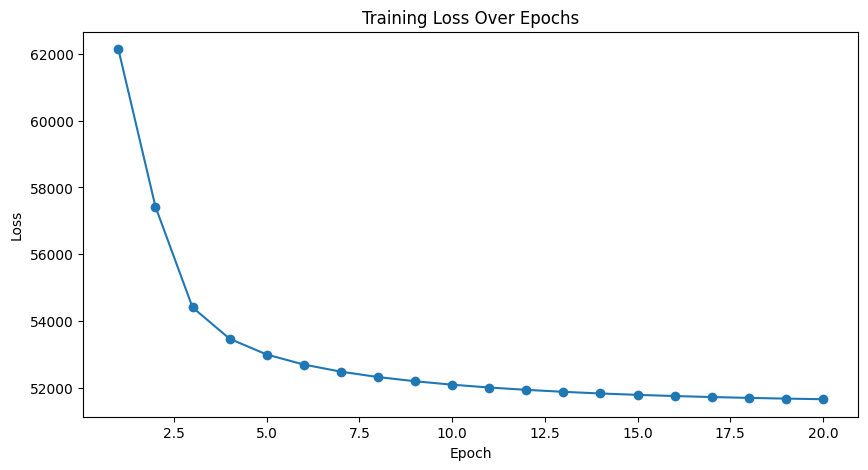

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'embeddings_trianing_loss.svg')
plt.show()

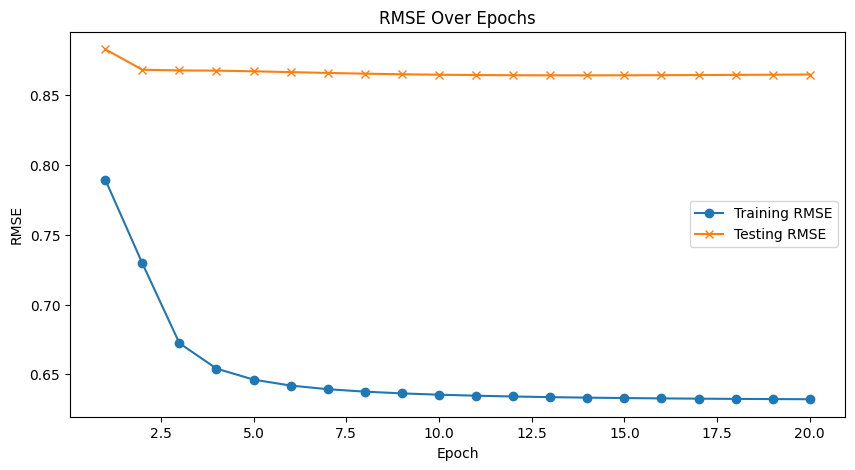

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'embeddings_rmse.svg')
plt.show()

#### Optimised with Vectorisation

In [14]:
def training_optimised_vectorised(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    num_users = len(user_ratings_train)
    num_items = len(movie_ratings_train)
    
    user_embeddings = np.random.normal(0, scale, (num_users, embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (num_items, embeddings_dim))
    user_biases = np.zeros(num_users)
    item_biases = np.zeros(num_items)

    tau_identity = tau * np.eye(embeddings_dim)

    training_loss, training_RMSE, testing_RMSE = [], [], []

    for epoch in range(num_epochs):
        # USER UPDATE
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            item_vecs = item_embeddings[movies]
            item_bias = item_biases[movies]

            preds = (item_vecs @ user_embeddings[u]) + item_bias
            residuals = actual_ratings - preds

            user_biases[u] = lam * np.sum(residuals) / ((lam * len(ratings)) + gamma)

            adjusted_residuals = actual_ratings - user_biases[u] - item_bias
            user_inverse_term = lam * (item_vecs.T @ item_vecs) + tau_identity
            user_term = lam * (item_vecs.T @ adjusted_residuals)

            user_embeddings[u] = np.linalg.solve(user_inverse_term, user_term)

        # ITEM UPDATE
        for m, ratings in enumerate(movie_ratings_train):
            users = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            user_vecs = user_embeddings[users]
            user_bias = user_biases[users]

            preds = (user_vecs @ item_embeddings[m]) + user_bias
            residuals = actual_ratings - preds

            item_biases[m] = lam * np.sum(residuals) / ((lam * len(ratings)) + gamma)

            adjusted_residuals = actual_ratings - user_bias - item_biases[m]
            item_inverse_term = lam * (user_vecs.T @ user_vecs) + tau_identity
            item_term = lam * (user_vecs.T @ adjusted_residuals)

            item_embeddings[m] = np.linalg.solve(item_inverse_term, item_term)

        # --- Training RMSE ---
        train_preds, train_actuals = [], []
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            train_preds.append(preds)
            train_actuals.append(actual_ratings)

        train_preds = np.concatenate(train_preds)
        train_actuals = np.concatenate(train_actuals)

        train_error = np.sum((train_actuals - train_preds) ** 2)
        train_rmse = np.sqrt(train_error / len(train_actuals))

        train_loss = (lam * train_error) \
            + (gamma * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2))) \
            + (tau * (np.sum(user_embeddings ** 2) + np.sum(item_embeddings ** 2)))
        
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        # --- Testing RMSE ---
        test_preds, test_actuals = [], []
        for u, ratings in enumerate(user_ratings_test):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            test_preds.append(preds)
            test_actuals.append(actual_ratings)

        test_preds = np.concatenate(test_preds)
        test_actuals = np.concatenate(test_actuals)

        test_error = np.sum((test_actuals - test_preds) ** 2)
        test_rmse = np.sqrt(test_error / len(test_actuals))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, [user_embeddings, item_embeddings], [user_biases, item_biases] 


#### Numba Version

In [15]:
import numpy as np
from numba import njit, prange
import time

# --- Data Preprocessing (Unchanged) ---
# This function is efficient and does not need changes.
def preprocess_ratings(data):
    """Converts a list of lists of ratings into a flattened COO-like format."""
    all_x, all_y, all_r = [], [], []
    ptrs = [0]
    for i, ratings in enumerate(data):
        for j, r in ratings:
            all_x.append(i)
            all_y.append(j)
            all_r.append(r)
        ptrs.append(len(all_r))
    return (
        np.array(all_x, dtype=np.int32),
        np.array(all_y, dtype=np.int32),
        np.array(all_r, dtype=np.float64),
        np.array(ptrs, dtype=np.int32)
    )

# --- OPTIMIZED Numba-Accelerated Updates (Parallel) ---
@njit(parallel=True, cache=True)
def update_user_embeddings(mu, num_users, user_ptrs, all_m, all_r,
                           user_embeddings, item_embeddings,
                           user_biases, item_biases,
                           lam, gamma, tau_identity):
    """
    Update user embeddings in parallel using the pre-calculated item embeddings.
    """
    dim = user_embeddings.shape[1]
    # This loop now runs in parallel across all available CPU cores
    for u in prange(num_users):
        start = user_ptrs[u]
        end = user_ptrs[u+1]
        n = end - start
        if n == 0:
            continue
            
        # Use fancy indexing to grab all necessary data at once
        movies = all_m[start:end]
        ratings = all_r[start:end]
        item_vecs = item_embeddings[movies]
        item_bias = item_biases[movies]
        
        # Perform vectorized prediction
        preds = item_vecs @ user_embeddings[u] + item_bias + mu
        
        residuals = ratings - preds
        user_bias = lam * np.sum(residuals) / (lam * n + gamma)
        user_biases[u] = user_bias
        
        # Solve for the new embedding
        adjusted = ratings - user_bias - item_bias - mu
        A = lam * (item_vecs.T @ item_vecs) + tau_identity
        b = lam * (item_vecs.T @ adjusted)
        user_embeddings[u] = np.linalg.solve(A, b)

@njit(parallel=True, cache=True)
def update_item_embeddings(mu, num_items, item_ptrs, all_u, all_r,
                           user_embeddings, item_embeddings,
                           user_biases, item_biases,
                           lam, gamma, tau_identity):
    """
    Update item embeddings in parallel using the pre-calculated user embeddings.
    """
    dim = item_embeddings.shape[1]
    # This loop also runs in parallel
    for m in prange(num_items):
        start = item_ptrs[m]
        end = item_ptrs[m+1]
        n = end - start
        if n == 0:
            continue
            
        # Use fancy indexing
        users = all_u[start:end]
        ratings = all_r[start:end]
        user_vecs = user_embeddings[users]
        user_bias = user_biases[users]
        
        # Vectorized prediction
        preds = user_vecs @ item_embeddings[m] + user_bias + mu
        
        residuals = ratings - preds
        item_bias = lam * np.sum(residuals) / (lam * n + gamma)
        item_biases[m] = item_bias
        
        # Solve for the new embedding
        adjusted = ratings - user_bias - item_bias - mu
        A = lam * (user_vecs.T @ user_vecs) + tau_identity
        b = lam * (user_vecs.T @ adjusted)
        item_embeddings[m] = np.linalg.solve(A, b)

# --- OPTIMIZED JIT-compiled evaluation function (Parallel) ---
@njit(parallel=True, cache=True)
def calculate_rmse_jit(mu, ptrs, all_user_indices, all_item_indices, all_ratings, 
                       user_embeddings, item_embeddings, user_biases, item_biases):
    """
    Calculates the Root Mean Squared Error in parallel.
    This function is generic and processes the data from a user-centric view.
    """
    total_squared_error = 0.0
    
    # Loop over all users in parallel
    for u in prange(len(ptrs) - 1):
        start, end = ptrs[u], ptrs[u+1]
        if start == end:
            continue
            
        item_idxs = all_item_indices[start:end]
        actuals = all_ratings[start:end]
        
        # Vectorized prediction for all items rated by this user
        preds = (user_embeddings[u] @ item_embeddings[item_idxs].T) + user_biases[u] + item_biases[item_idxs] + mu
        
        # Numba automatically handles thread-safe summation for reduction operations
        total_squared_error += np.sum((actuals - preds) ** 2)

    return np.sqrt(total_squared_error / len(all_ratings))

# --- OPTIMIZED Main Training Function ---
def training_als_from_preprocessed(
    mu, 
    num_users, num_items,
    all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
    all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
    all_u_test, all_m_test, all_r_test, user_ptrs_test,
    num_epochs=20, lam=0.1, gamma=0.1, tau=0.1,
    embeddings_dim=20, scale=0.1
):
    """
    Optimized ALS training using preprocessed data.
    """
    print("Starting ALS optimization (preprocessed)...")
    start_time = time.time()

    user_embeddings = np.random.normal(0, scale, (num_users, embeddings_dim)).astype(np.float64)
    item_embeddings = np.random.normal(0, scale, (num_items, embeddings_dim)).astype(np.float64)
    user_biases = np.zeros(num_users, dtype=np.float64)
    item_biases = np.zeros(num_items, dtype=np.float64)
    tau_identity = np.ascontiguousarray(tau * np.eye(embeddings_dim, dtype=np.float64))

    training_RMSE, testing_RMSE = [], []

    for epoch in range(num_epochs):
        epoch_start = time.time()

        update_user_embeddings(mu, num_users, user_ptrs_train, all_m_train, all_r_train_u,
                               user_embeddings, item_embeddings,
                               user_biases, item_biases,
                               lam, gamma, tau_identity)

        update_item_embeddings(mu, num_items, item_ptrs_train, all_u_rev_train, all_r_train_m,
                               user_embeddings, item_embeddings,
                               user_biases, item_biases,
                               lam, gamma, tau_identity)

        train_rmse = calculate_rmse_jit(mu, user_ptrs_train, all_u_train, all_m_train, all_r_train_u,
                                        user_embeddings, item_embeddings,
                                        user_biases, item_biases)

        test_rmse = calculate_rmse_jit(mu, user_ptrs_test, all_u_test, all_m_test, all_r_test,
                                       user_embeddings, item_embeddings,
                                       user_biases, item_biases)

        training_RMSE.append(train_rmse)
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f} | Time: {time.time() - epoch_start:.2f}s")

    print(f"Finished training. Total time: {time.time() - start_time:.2f}s")

    return training_RMSE, testing_RMSE, [user_embeddings, item_embeddings], [user_biases, item_biases]

## Optuna Section

In [16]:
def objective(trial):
    lam = trial.suggest_float('lam', 1e-1, 10.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-1, 10.0, log=True)
    tau = trial.suggest_float('tau', 1e-1, 10.0, log=True)
    embeddings_dim = trial.suggest_int('embeddings_dim', 10, 30)
    scale = trial.suggest_float('scale', 0.01, 1.0)

    num_epochs = 20
    
    training_RMSE, testing_RMSE, _, _ = training_als_from_preprocessed(
        ratings_mean,
        num_users, num_items,
        all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
        all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
        all_u_test, all_m_test, all_r_test, user_ptrs_test,
        num_epochs=10, lam=lam, gamma=gamma, tau=tau,
        embeddings_dim=embeddings_dim, scale=scale
    )

    return testing_RMSE[-1]

In [17]:
folder_name = external_data_path + "ml-32m"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

In [18]:
min_ratings_per_movie = 10

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []

test_count = 0
train_count = 0
start_time = time.time()

# First pass: count movie ratings
movie_rating_counts = {}

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            movie_id = row[1]
            movie_rating_counts[movie_id] = movie_rating_counts.get(movie_id, 0) + 1
except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred during first pass: {e}")

# Filter movies by rating count
valid_movies = {movie_id for movie_id, count in movie_rating_counts.items() if count >= min_ratings_per_movie}

# Second pass: process ratings
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if movie_id not in valid_movies:
                continue  # Skip movies with too few ratings

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_train.append([])
                user_ratings_test.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([])
                movie_ratings_test.append([])

            user_idx = user_to_idx[user_id]
            movie_idx = movie_to_idx[movie_id]

            user_seen_before = len(user_ratings_train[user_idx]) > 0
            movie_seen_before = len(movie_ratings_train[movie_idx]) > 0

            if not user_seen_before or not movie_seen_before or random.random() < train_ratio:
                # Assign to training set
                user_ratings_train[user_idx].append((movie_idx, rating))
                movie_ratings_train[movie_idx].append((user_idx, rating))
                train_count += 1
            else:
                # Assign to test set (only if both user and movie are known from training)
                user_ratings_test[user_idx].append((movie_idx, rating))
                movie_ratings_test[movie_idx].append((user_idx, rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred during second pass: {e}")

end_time = time.time()

# --- Logging ---
print("Finished")
print("Time taken:", round(end_time - start_time, 2), "seconds")
print("Train Count:", train_count)
print("Test Count:", test_count)
print("Unique Users:", len(user_to_idx))
print("Valid Movies (after filter):", len(movie_to_idx))

Finished
Time taken: 82.92 seconds
Train Count: 25520667
Test Count: 6322038
Unique Users: 200948
Valid Movies (after filter): 31961


In [19]:
all_u_train, all_m_train, all_r_train_u, user_ptrs_train = preprocess_ratings(user_ratings_train)
all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train = preprocess_ratings(movie_ratings_train)
all_u_test, all_m_test, all_r_test, user_ptrs_test = preprocess_ratings(user_ratings_test)

num_users = len(user_ratings_train)
num_items = len(movie_ratings_train)

ratings_mean = np.mean(all_r_train_u)

## Training Implementation

In [20]:
# Define persistent storage
storage_name = "sqlite:///optuna_study.db"  # File-based SQLite DB
study_name = "matrix_factorization_study"

# Define these before the block if needed
best_params = {}
best_rmse = 0

# === Run optimization or load from file ===
if optuna_optimisation:
    # Create or load study from SQLite DB
    study = optuna.create_study(
        study_name=study_name,
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(),
        storage=storage_name,
        load_if_exists=True
    )
    
    # Optimize the objective function
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_rmse = study.best_value

    # Save best params to text file for human-readable record
    with open('best_hyperparams.txt', 'w') as f:
        for param, value in best_params.items():
            f.write(f"{param}: {value}\n")
        f.write(f"Best Test RMSE: {best_rmse}\n")

else:
    # Load best params from text file if not running optimization
    if os.path.exists('best_hyperparams.txt'):
        with open('best_hyperparams.txt', 'r') as f:
            for line in f:
                if ':' in line:
                    key, value = line.strip().split(':')
                    key = key.strip()
                    value = value.strip()
                    if key == 'Best Test RMSE':
                        best_rmse = float(value)
                    else:
                        try:
                            value = int(value)
                        except ValueError:
                            try:
                                value = float(value)
                            except ValueError:
                                pass
                        best_params[key] = value
    else:
        raise FileNotFoundError("best_hyperparams.txt not found. Run with optuna_optimisation=True first.")

# Extract parameters safely
lam = best_params.get('lam')
gamma = best_params.get('gamma')
tau = best_params.get('tau')
embeddings_dim = best_params.get('embeddings_dim')
scale = best_params.get('scale')

print("Best Hyperparameters:", best_params)
print("Best Test RMSE:", best_rmse)


Best Hyperparameters: {'lam': 0.2967578122000694, 'gamma': 0.21104871252319177, 'tau': 7.536619368542641, 'embeddings_dim': 20, 'scale': 0.4123235301422883}
Best Test RMSE: 0.7733958234618036


In [22]:
num_epochs = 50
# embeddings_dim = 10
training_RMSE, testing_RMSE, embeddings, biases = training_als_from_preprocessed(
        ratings_mean,
        num_users, num_items,
        all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
        all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
        all_u_test, all_m_test, all_r_test, user_ptrs_test,
        num_epochs=num_epochs, lam=lam, gamma=gamma, tau=tau,
        embeddings_dim=embeddings_dim, scale=scale
    )

Starting ALS optimization (preprocessed)...
Epoch 1/50 | Train RMSE: 0.8173 | Test RMSE: 0.8816 | Time: 43.42s
Epoch 2/50 | Train RMSE: 0.7420 | Test RMSE: 0.8240 | Time: 2.79s
Epoch 3/50 | Train RMSE: 0.7144 | Test RMSE: 0.7989 | Time: 2.91s
Epoch 4/50 | Train RMSE: 0.7030 | Test RMSE: 0.7879 | Time: 3.27s
Epoch 5/50 | Train RMSE: 0.6972 | Test RMSE: 0.7822 | Time: 3.29s
Epoch 6/50 | Train RMSE: 0.6939 | Test RMSE: 0.7789 | Time: 3.71s
Epoch 7/50 | Train RMSE: 0.6918 | Test RMSE: 0.7768 | Time: 4.07s
Epoch 8/50 | Train RMSE: 0.6904 | Test RMSE: 0.7754 | Time: 4.12s
Epoch 9/50 | Train RMSE: 0.6894 | Test RMSE: 0.7744 | Time: 3.55s
Epoch 10/50 | Train RMSE: 0.6887 | Test RMSE: 0.7737 | Time: 3.53s
Epoch 11/50 | Train RMSE: 0.6881 | Test RMSE: 0.7731 | Time: 3.64s
Epoch 12/50 | Train RMSE: 0.6877 | Test RMSE: 0.7727 | Time: 3.64s
Epoch 13/50 | Train RMSE: 0.6874 | Test RMSE: 0.7724 | Time: 3.54s
Epoch 14/50 | Train RMSE: 0.6872 | Test RMSE: 0.7721 | Time: 3.74s
Epoch 15/50 | Train RMSE: 

In [23]:
save_dir = os.path.join("..", "models")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "recommender_model_params.npz")

np.savez_compressed(
    save_path,
    user_embeddings=embeddings[0],
    item_embeddings=embeddings[1],
    user_biases=biases[0],
    item_biases=biases[1]
)

print(user_embeddings[0])
print(item_embeddings[0])

[ 0.12338416 -0.1364402  -0.05095342  0.2682981   0.20950711 -0.20186938
 -0.08711     0.23593254 -0.03769769  0.14805621]
[-0.20205293  0.00822126 -0.34886912  0.2215885  -0.03889158 -0.22284746
  0.08717537 -0.58671632 -0.10151746 -0.10674269]


In [24]:
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Epochs')
# plt.savefig(image_path + 'large_embeddings_trianing_loss.svg')
# plt.show()

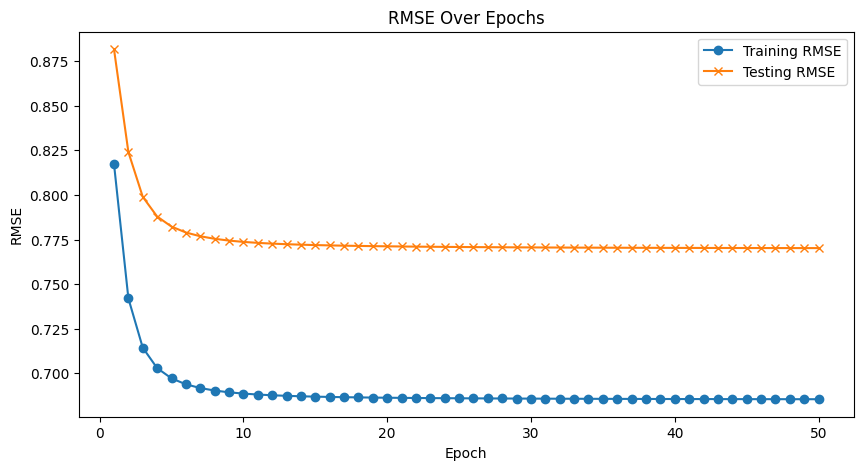

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'large_embeddings_rmse.svg')
plt.show()

## Evaluation

In [26]:
save_dir = os.path.join("..", "models")
save_path = os.path.join(save_dir, "recommender_model_params.npz")

# Load the model parameters
with np.load(save_path, allow_pickle=True) as data:
    user_embeddings = data['user_embeddings']
    item_embeddings = data['item_embeddings']
    user_biases = data['user_biases']
    item_biases = data['item_biases']

print("User Embeddings Shape:", user_embeddings.shape)
print("Item Embeddings Shape:", item_embeddings.shape)
print("User Biases Shape:", user_biases.shape)
print("Item Biases Shape:", item_biases.shape)

User Embeddings Shape: (200948, 20)
Item Embeddings Shape: (31961, 20)
User Biases Shape: (200948,)
Item Biases Shape: (31961,)


In [27]:
folder_name = external_data_path + "ml-32m"
file_name = "movies.csv" 
file_path = os.path.join(folder_name, file_name)

movie_id_to_movie_name = {}
movie_name_to_movie_id = {}

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            movie_id = row[0]
            movie_name = row[1]

            if movie_id not in movie_id_to_movie_name:
                movie_id_to_movie_name[movie_id] = movie_name
                movie_name_to_movie_id[movie_name] = movie_id

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [39]:
user_id = "dummy_user"
movie_id = "742"
rating = 5

user_idx = len(user_to_idx)
user_to_idx[user_id] = user_idx
idx_to_user[user_idx] = user_id
movie = movie_to_idx[movie_id]

In [40]:
num_epochs = 50
# embeddings_dim = 10

dummy_user_embedding = np.random.normal(0, scale, embeddings_dim)
dummy_user_bias = 0
movie_embedding = item_embeddings[movie]
movie_bias = item_biases[movie]

tau_identity = tau * np.eye(embeddings_dim)

training_loss, training_RMSE, testing_RMSE = [], [], []

for epoch in range(num_epochs):
    actual_rating = rating
    pred = (dummy_user_embedding @ movie_embedding) + dummy_user_bias + movie_bias
    residual = actual_rating - pred

    dummy_user_bias = lam * residual / ((lam * 1) + gamma)

    adjusted_residual = actual_rating - dummy_user_bias - movie_bias
    user_inverse_term = lam * np.outer(movie_embedding, movie_embedding) + tau_identity
    user_term = lam * (movie_embedding * adjusted_residual)

    dummy_user_embedding = np.linalg.solve(user_inverse_term, user_term)

    pred = (dummy_user_embedding @ movie_embedding) + dummy_user_bias + movie_bias
    train_error = actual_rating - pred
    train_loss = (lam * train_error ** 2) \
        + (gamma * (np.sum(dummy_user_bias ** 2) + np.sum(item_biases[movie] ** 2))) \
        + (tau * (np.sum(dummy_user_embedding ** 2) + np.sum(item_embeddings[movie] ** 2)))


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

Epoch 1/50, Loss: 26.3476
Epoch 2/50, Loss: 28.4258
Epoch 3/50, Loss: 26.5015
Epoch 4/50, Loss: 27.2800
Epoch 5/50, Loss: 26.8094
Epoch 6/50, Loss: 27.0386
Epoch 7/50, Loss: 26.9138
Epoch 8/50, Loss: 26.9779
Epoch 9/50, Loss: 26.9440
Epoch 10/50, Loss: 26.9616
Epoch 11/50, Loss: 26.9524
Epoch 12/50, Loss: 26.9572
Epoch 13/50, Loss: 26.9547
Epoch 14/50, Loss: 26.9560
Epoch 15/50, Loss: 26.9553
Epoch 16/50, Loss: 26.9557
Epoch 17/50, Loss: 26.9555
Epoch 18/50, Loss: 26.9556
Epoch 19/50, Loss: 26.9555
Epoch 20/50, Loss: 26.9556
Epoch 21/50, Loss: 26.9555
Epoch 22/50, Loss: 26.9556
Epoch 23/50, Loss: 26.9555
Epoch 24/50, Loss: 26.9556
Epoch 25/50, Loss: 26.9555
Epoch 26/50, Loss: 26.9556
Epoch 27/50, Loss: 26.9555
Epoch 28/50, Loss: 26.9555
Epoch 29/50, Loss: 26.9555
Epoch 30/50, Loss: 26.9555
Epoch 31/50, Loss: 26.9555
Epoch 32/50, Loss: 26.9555
Epoch 33/50, Loss: 26.9555
Epoch 34/50, Loss: 26.9555
Epoch 35/50, Loss: 26.9555
Epoch 36/50, Loss: 26.9555
Epoch 37/50, Loss: 26.9555
Epoch 38/5

In [41]:
# from collections import defaultdict

# folder_name = external_data_path + "ml-32m"
# file_name = "ratings.csv"
# file_path = os.path.join(folder_name, file_name)

# movie_rating_counts = defaultdict(int)

# with open(file_path, newline='') as csvfile:
#     reader = csv.reader(csvfile)
#     header = next(reader)  # skip header
#     for user_id, movie_id, rating, timestamp in reader:
#         movie_rating_counts[movie_id] += 1

# popular_movies = [movie_id for movie_id, count in movie_rating_counts.items() if count > 100]

In [42]:
print(dummy_user_embedding)
print(item_embeddings[movie])
print(dummy_user_bias)
print(item_biases[movie])
print(movie_id_to_movie_name[idx_to_movie[movie]])
# actual_ratings = []
# for u, ratings in enumerate(user_ratings_train):
#     actual_ratings.append(r for _, r in ratings)

# Predict ratings for all movies for the dummy user
# mapped_indices = [movie_to_idx[mid] for mid in popular_movies]
predicted_ratings = dummy_user_embedding @ item_embeddings.T + item_biases

top_N = 10  # or however many you want to see
top_movie_indices = np.argsort(predicted_ratings)[::-1][:top_N]

# If you have a mapping from movie indices to titles
for idx in top_movie_indices:
    print(f"Movie: {movie_id_to_movie_name[idx_to_movie[idx]]}, Predicted Rating: {predicted_ratings[idx]:.2f}")

[ 0.02559774 -0.06380225  0.05203797  0.01951864  0.01968364  0.01800328
 -0.00991925  0.09465775 -0.01599367 -0.002279    0.06668754 -0.00507603
  0.07852603  0.09363994 -0.0713628   0.01762361  0.01835436 -0.03193375
 -0.00794571 -0.09291398]
[ 0.19121208 -0.47659532  0.3887175   0.14580199  0.14703446  0.13448243
 -0.07409564  0.70708226 -0.11947085 -0.01702387  0.49814812 -0.03791735
  0.5865802   0.69947938 -0.53307177  0.13164629  0.13710492 -0.2385414
 -0.05935349 -0.69405653]
1.9868474420992381
-0.7804398700529259
Thinner (1996)
Movie: Emilie Muller (1994), Predicted Rating: 1.18
Movie: Dara Ó Briain: Craic Dealer (2012), Predicted Rating: 1.14
Movie: Michael Jackson: Dangerous Tour (Bucharest, 1992) (1992), Predicted Rating: 1.14
Movie: Born in the USSR: 21 Up (2005), Predicted Rating: 1.07
Movie: Company: A Musical Comedy (2008), Predicted Rating: 1.04
Movie: Day the Universe Changed, The (1985), Predicted Rating: 1.03
Movie: Fishing with John (1991), Predicted Rating: 1.02
M

## Embeddings Visualisation

In [44]:
def objective(trial):
    lam = trial.suggest_float('lam', 1e-1, 10.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-1, 10.0, log=True)
    tau = trial.suggest_float('tau', 1e-1, 10.0, log=True)
    scale = trial.suggest_float('scale', 0.01, 1.0)

    num_epochs = 20
    
    training_RMSE, testing_RMSE, _, _ = training_als_from_preprocessed(
        ratings_mean,
        num_users, num_items,
        all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
        all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
        all_u_test, all_m_test, all_r_test, user_ptrs_test,
        num_epochs=10, lam=lam, gamma=gamma, tau=tau,
        embeddings_dim=2, scale=scale
    )

    return testing_RMSE[-1]

study = optuna.create_study(
    study_name=study_name,
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(),
    storage=storage_name,
    load_if_exists=True
)

# Optimize the objective function
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_rmse = study.best_value

# Save best params to text file for human-readable record
with open('best_hyperparams.txt', 'w') as f:
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")
    f.write(f"Best Test RMSE: {best_rmse}\n")

lam = best_params.get('lam')
gamma = best_params.get('gamma')
tau = best_params.get('tau')
scale = best_params.get('scale')

[I 2025-07-26 19:06:46,290] Using an existing study with name 'matrix_factorization_study' instead of creating a new one.


Starting ALS optimization (preprocessed)...
Epoch 1/10 | Train RMSE: 0.8582 | Test RMSE: 0.8700 | Time: 1.15s
Epoch 2/10 | Train RMSE: 0.8230 | Test RMSE: 0.8381 | Time: 0.53s
Epoch 3/10 | Train RMSE: 0.8104 | Test RMSE: 0.8267 | Time: 0.48s
Epoch 4/10 | Train RMSE: 0.8063 | Test RMSE: 0.8229 | Time: 0.45s
Epoch 5/10 | Train RMSE: 0.8047 | Test RMSE: 0.8214 | Time: 0.44s
Epoch 6/10 | Train RMSE: 0.8039 | Test RMSE: 0.8207 | Time: 0.46s
Epoch 7/10 | Train RMSE: 0.8036 | Test RMSE: 0.8203 | Time: 0.52s
Epoch 8/10 | Train RMSE: 0.8033 | Test RMSE: 0.8201 | Time: 0.43s
Epoch 9/10 | Train RMSE: 0.8032 | Test RMSE: 0.8200 | Time: 0.45s


[I 2025-07-26 19:06:51,825] Trial 472 finished with value: 0.8199057024457841 and parameters: {'lam': 0.2152039295914305, 'gamma': 0.14179250739006105, 'tau': 9.994340579926874, 'scale': 0.43905561520745706}. Best is trial 60 with value: 0.7733958234618036.


Epoch 10/10 | Train RMSE: 0.8031 | Test RMSE: 0.8199 | Time: 0.45s
Finished training. Total time: 5.38s
Starting ALS optimization (preprocessed)...
Epoch 1/10 | Train RMSE: 0.8593 | Test RMSE: 0.8694 | Time: 0.44s
Epoch 2/10 | Train RMSE: 0.8293 | Test RMSE: 0.8457 | Time: 0.45s
Epoch 3/10 | Train RMSE: 0.8200 | Test RMSE: 0.8372 | Time: 0.43s
Epoch 4/10 | Train RMSE: 0.8153 | Test RMSE: 0.8329 | Time: 0.45s
Epoch 5/10 | Train RMSE: 0.8111 | Test RMSE: 0.8289 | Time: 0.50s
Epoch 6/10 | Train RMSE: 0.8068 | Test RMSE: 0.8247 | Time: 0.48s
Epoch 7/10 | Train RMSE: 0.8032 | Test RMSE: 0.8211 | Time: 0.46s
Epoch 8/10 | Train RMSE: 0.8009 | Test RMSE: 0.8189 | Time: 0.55s
Epoch 9/10 | Train RMSE: 0.7997 | Test RMSE: 0.8177 | Time: 0.47s


[I 2025-07-26 19:06:56,669] Trial 473 finished with value: 0.8171684496195143 and parameters: {'lam': 0.28383273904985695, 'gamma': 0.11916336223993826, 'tau': 8.003528546098762, 'scale': 0.07742844063931746}. Best is trial 60 with value: 0.7733958234618036.


Epoch 10/10 | Train RMSE: 0.7991 | Test RMSE: 0.8172 | Time: 0.47s
Finished training. Total time: 4.73s
Starting ALS optimization (preprocessed)...
Epoch 1/10 | Train RMSE: 0.8562 | Test RMSE: 0.8726 | Time: 0.49s
Epoch 2/10 | Train RMSE: 0.8281 | Test RMSE: 0.8474 | Time: 0.47s
Epoch 3/10 | Train RMSE: 0.8100 | Test RMSE: 0.8296 | Time: 0.50s
Epoch 4/10 | Train RMSE: 0.8010 | Test RMSE: 0.8209 | Time: 0.48s
Epoch 5/10 | Train RMSE: 0.7978 | Test RMSE: 0.8179 | Time: 0.46s
Epoch 6/10 | Train RMSE: 0.7966 | Test RMSE: 0.8167 | Time: 0.45s
Epoch 7/10 | Train RMSE: 0.7960 | Test RMSE: 0.8161 | Time: 0.47s
Epoch 8/10 | Train RMSE: 0.7956 | Test RMSE: 0.8158 | Time: 0.50s
Epoch 9/10 | Train RMSE: 0.7954 | Test RMSE: 0.8156 | Time: 0.50s


[I 2025-07-26 19:07:01,557] Trial 474 finished with value: 0.8154301409692596 and parameters: {'lam': 0.3283237711706683, 'gamma': 0.16136251465273302, 'tau': 4.54409624613907, 'scale': 0.38668732927532046}. Best is trial 60 with value: 0.7733958234618036.


Epoch 10/10 | Train RMSE: 0.7952 | Test RMSE: 0.8154 | Time: 0.45s
Finished training. Total time: 4.78s
Starting ALS optimization (preprocessed)...
Epoch 1/10 | Train RMSE: 0.8575 | Test RMSE: 0.8704 | Time: 0.46s
Epoch 2/10 | Train RMSE: 0.8247 | Test RMSE: 0.8402 | Time: 0.45s
Epoch 3/10 | Train RMSE: 0.8095 | Test RMSE: 0.8261 | Time: 0.44s
Epoch 4/10 | Train RMSE: 0.8050 | Test RMSE: 0.8221 | Time: 0.44s
Epoch 5/10 | Train RMSE: 0.8031 | Test RMSE: 0.8204 | Time: 0.46s
Epoch 6/10 | Train RMSE: 0.8021 | Test RMSE: 0.8195 | Time: 0.45s
Epoch 7/10 | Train RMSE: 0.8014 | Test RMSE: 0.8189 | Time: 0.48s
Epoch 8/10 | Train RMSE: 0.8010 | Test RMSE: 0.8185 | Time: 0.48s
Epoch 9/10 | Train RMSE: 0.8007 | Test RMSE: 0.8182 | Time: 0.50s


[I 2025-07-26 19:07:06,289] Trial 475 finished with value: 0.8180073413795361 and parameters: {'lam': 0.24292637599523462, 'gamma': 0.18579416933220935, 'tau': 8.455354854511564, 'scale': 0.45229599606703264}. Best is trial 60 with value: 0.7733958234618036.


Epoch 10/10 | Train RMSE: 0.8004 | Test RMSE: 0.8180 | Time: 0.47s
Finished training. Total time: 4.63s
Starting ALS optimization (preprocessed)...
Epoch 1/10 | Train RMSE: 0.8560 | Test RMSE: 0.8707 | Time: 0.47s
Epoch 2/10 | Train RMSE: 0.8202 | Test RMSE: 0.8373 | Time: 0.51s
Epoch 3/10 | Train RMSE: 0.8077 | Test RMSE: 0.8260 | Time: 0.45s
Epoch 4/10 | Train RMSE: 0.8039 | Test RMSE: 0.8226 | Time: 0.51s
Epoch 5/10 | Train RMSE: 0.8026 | Test RMSE: 0.8214 | Time: 0.51s
Epoch 6/10 | Train RMSE: 0.8019 | Test RMSE: 0.8207 | Time: 0.47s
Epoch 7/10 | Train RMSE: 0.8016 | Test RMSE: 0.8204 | Time: 0.58s
Epoch 8/10 | Train RMSE: 0.8014 | Test RMSE: 0.8202 | Time: 0.50s
Epoch 9/10 | Train RMSE: 0.8012 | Test RMSE: 0.8200 | Time: 0.48s


[I 2025-07-26 19:07:11,411] Trial 476 finished with value: 0.8198683939944187 and parameters: {'lam': 0.3569249011541625, 'gamma': 0.13082698154047523, 'tau': 9.247063007505567, 'scale': 0.5005192901404306}. Best is trial 60 with value: 0.7733958234618036.


Epoch 10/10 | Train RMSE: 0.8011 | Test RMSE: 0.8199 | Time: 0.52s
Finished training. Total time: 5.02s
Starting ALS optimization (preprocessed)...
Epoch 1/10 | Train RMSE: 0.8555 | Test RMSE: 0.8726 | Time: 0.45s
Epoch 2/10 | Train RMSE: 0.8267 | Test RMSE: 0.8460 | Time: 0.45s
Epoch 3/10 | Train RMSE: 0.8130 | Test RMSE: 0.8330 | Time: 0.45s
Epoch 4/10 | Train RMSE: 0.8057 | Test RMSE: 0.8261 | Time: 0.50s
Epoch 5/10 | Train RMSE: 0.8010 | Test RMSE: 0.8215 | Time: 0.47s
Epoch 6/10 | Train RMSE: 0.7981 | Test RMSE: 0.8186 | Time: 0.46s
Epoch 7/10 | Train RMSE: 0.7963 | Test RMSE: 0.8170 | Time: 0.46s
Epoch 8/10 | Train RMSE: 0.7953 | Test RMSE: 0.8160 | Time: 0.48s
Epoch 9/10 | Train RMSE: 0.7946 | Test RMSE: 0.8153 | Time: 0.45s


[I 2025-07-26 19:07:16,312] Trial 477 finished with value: 0.8148844076966968 and parameters: {'lam': 0.5378911254570405, 'gamma': 0.14856810937232573, 'tau': 6.516551229597958, 'scale': 0.4046735847636824}. Best is trial 60 with value: 0.7733958234618036.


Epoch 10/10 | Train RMSE: 0.7941 | Test RMSE: 0.8149 | Time: 0.63s
Finished training. Total time: 4.80s
Starting ALS optimization (preprocessed)...
Epoch 1/10 | Train RMSE: 0.8553 | Test RMSE: 0.8741 | Time: 0.47s
Epoch 2/10 | Train RMSE: 0.8262 | Test RMSE: 0.8472 | Time: 0.48s
Epoch 3/10 | Train RMSE: 0.8043 | Test RMSE: 0.8255 | Time: 0.46s
Epoch 4/10 | Train RMSE: 0.7957 | Test RMSE: 0.8176 | Time: 0.45s
Epoch 5/10 | Train RMSE: 0.7928 | Test RMSE: 0.8148 | Time: 0.46s
Epoch 6/10 | Train RMSE: 0.7915 | Test RMSE: 0.8137 | Time: 0.49s
Epoch 7/10 | Train RMSE: 0.7908 | Test RMSE: 0.8131 | Time: 0.46s
Epoch 8/10 | Train RMSE: 0.7904 | Test RMSE: 0.8127 | Time: 0.46s
Epoch 9/10 | Train RMSE: 0.7902 | Test RMSE: 0.8125 | Time: 0.47s


[I 2025-07-26 19:07:21,108] Trial 478 finished with value: 0.8123738955428768 and parameters: {'lam': 1.3287245647473862, 'gamma': 0.2179322496237398, 'tau': 7.371032648600713, 'scale': 0.31161092297801085}. Best is trial 60 with value: 0.7733958234618036.


Epoch 10/10 | Train RMSE: 0.7900 | Test RMSE: 0.8124 | Time: 0.47s
Finished training. Total time: 4.69s
Starting ALS optimization (preprocessed)...
Epoch 1/10 | Train RMSE: 0.8572 | Test RMSE: 0.8703 | Time: 0.51s
Epoch 2/10 | Train RMSE: 0.8304 | Test RMSE: 0.8470 | Time: 0.46s
Epoch 3/10 | Train RMSE: 0.8183 | Test RMSE: 0.8359 | Time: 0.46s
Epoch 4/10 | Train RMSE: 0.8108 | Test RMSE: 0.8287 | Time: 0.46s
Epoch 5/10 | Train RMSE: 0.8067 | Test RMSE: 0.8247 | Time: 0.45s
Epoch 6/10 | Train RMSE: 0.8044 | Test RMSE: 0.8224 | Time: 0.46s
Epoch 7/10 | Train RMSE: 0.8031 | Test RMSE: 0.8210 | Time: 0.46s
Epoch 8/10 | Train RMSE: 0.8021 | Test RMSE: 0.8201 | Time: 0.48s
Epoch 9/10 | Train RMSE: 0.8014 | Test RMSE: 0.8193 | Time: 0.47s


[I 2025-07-26 19:07:25,914] Trial 479 finished with value: 0.8187258806692108 and parameters: {'lam': 0.19791997110157528, 'gamma': 0.16768186254575793, 'tau': 5.8390277091734895, 'scale': 0.3436832488552816}. Best is trial 60 with value: 0.7733958234618036.


Epoch 10/10 | Train RMSE: 0.8007 | Test RMSE: 0.8187 | Time: 0.46s
Finished training. Total time: 4.70s
Starting ALS optimization (preprocessed)...
Epoch 1/10 | Train RMSE: 0.8566 | Test RMSE: 0.8716 | Time: 0.47s
Epoch 2/10 | Train RMSE: 0.8281 | Test RMSE: 0.8464 | Time: 0.48s
Epoch 3/10 | Train RMSE: 0.8109 | Test RMSE: 0.8299 | Time: 0.50s
Epoch 4/10 | Train RMSE: 0.8030 | Test RMSE: 0.8223 | Time: 0.47s
Epoch 5/10 | Train RMSE: 0.7995 | Test RMSE: 0.8190 | Time: 0.48s
Epoch 6/10 | Train RMSE: 0.7975 | Test RMSE: 0.8172 | Time: 0.45s
Epoch 7/10 | Train RMSE: 0.7963 | Test RMSE: 0.8161 | Time: 0.46s
Epoch 8/10 | Train RMSE: 0.7956 | Test RMSE: 0.8154 | Time: 0.45s
Epoch 9/10 | Train RMSE: 0.7951 | Test RMSE: 0.8150 | Time: 0.46s


[I 2025-07-26 19:07:30,690] Trial 480 finished with value: 0.8147500762605278 and parameters: {'lam': 0.29781598338586585, 'gamma': 0.11665005584887111, 'tau': 4.871653097178843, 'scale': 0.2772786145877931}. Best is trial 60 with value: 0.7733958234618036.


Epoch 10/10 | Train RMSE: 0.7949 | Test RMSE: 0.8148 | Time: 0.45s
Finished training. Total time: 4.68s
Starting ALS optimization (preprocessed)...
Epoch 1/10 | Train RMSE: 0.8586 | Test RMSE: 0.8699 | Time: 0.47s
Epoch 2/10 | Train RMSE: 0.8273 | Test RMSE: 0.8420 | Time: 0.50s
Epoch 3/10 | Train RMSE: 0.8120 | Test RMSE: 0.8277 | Time: 0.46s
Epoch 4/10 | Train RMSE: 0.8065 | Test RMSE: 0.8226 | Time: 0.51s
Epoch 5/10 | Train RMSE: 0.8045 | Test RMSE: 0.8208 | Time: 0.46s
Epoch 6/10 | Train RMSE: 0.8037 | Test RMSE: 0.8201 | Time: 0.46s
Epoch 7/10 | Train RMSE: 0.8032 | Test RMSE: 0.8197 | Time: 0.46s
Epoch 8/10 | Train RMSE: 0.8030 | Test RMSE: 0.8195 | Time: 0.45s
Epoch 9/10 | Train RMSE: 0.8028 | Test RMSE: 0.8194 | Time: 0.46s


[I 2025-07-26 19:07:35,497] Trial 481 finished with value: 0.8193282569887993 and parameters: {'lam': 0.1687545924581629, 'gamma': 0.14421033449784398, 'tau': 8.004191644032595, 'scale': 0.36876275660632074}. Best is trial 60 with value: 0.7733958234618036.


Epoch 10/10 | Train RMSE: 0.8027 | Test RMSE: 0.8193 | Time: 0.47s
Finished training. Total time: 4.70s


In [45]:
num_epochs = 50
# embeddings_dim = 10
training_RMSE, testing_RMSE, embeddings, biases = training_als_from_preprocessed(
        ratings_mean,
        num_users, num_items,
        all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
        all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
        all_u_test, all_m_test, all_r_test, user_ptrs_test,
        num_epochs=num_epochs, lam=lam, gamma=gamma, tau=tau,
        embeddings_dim=2, scale=scale
    )

Starting ALS optimization (preprocessed)...
Epoch 1/50 | Train RMSE: 0.8557 | Test RMSE: 0.8698 | Time: 0.50s
Epoch 2/50 | Train RMSE: 0.8215 | Test RMSE: 0.8387 | Time: 0.47s
Epoch 3/50 | Train RMSE: 0.8099 | Test RMSE: 0.8277 | Time: 0.46s
Epoch 4/50 | Train RMSE: 0.8058 | Test RMSE: 0.8240 | Time: 0.47s
Epoch 5/50 | Train RMSE: 0.8040 | Test RMSE: 0.8223 | Time: 0.50s
Epoch 6/50 | Train RMSE: 0.8030 | Test RMSE: 0.8213 | Time: 0.46s
Epoch 7/50 | Train RMSE: 0.8023 | Test RMSE: 0.8207 | Time: 0.46s
Epoch 8/50 | Train RMSE: 0.8018 | Test RMSE: 0.8202 | Time: 0.46s
Epoch 9/50 | Train RMSE: 0.8013 | Test RMSE: 0.8197 | Time: 0.45s
Epoch 10/50 | Train RMSE: 0.8009 | Test RMSE: 0.8193 | Time: 0.49s
Epoch 11/50 | Train RMSE: 0.8005 | Test RMSE: 0.8189 | Time: 0.47s
Epoch 12/50 | Train RMSE: 0.8001 | Test RMSE: 0.8185 | Time: 0.47s
Epoch 13/50 | Train RMSE: 0.7997 | Test RMSE: 0.8181 | Time: 0.46s
Epoch 14/50 | Train RMSE: 0.7994 | Test RMSE: 0.8178 | Time: 0.46s
Epoch 15/50 | Train RMSE: 0

LOTR Similar Movies: ['Tombstone (1993)', 'Matilda (1996)', 'No Way Out (1987)', 'Stand and Deliver (1988)', 'Amistad (1997)', 'Bedknobs and Broomsticks (1971)', 'Song of the South (1946)', 'Mean Girls (2004)', 'South Pacific (1958)', 'Sandlot, The (1993)']


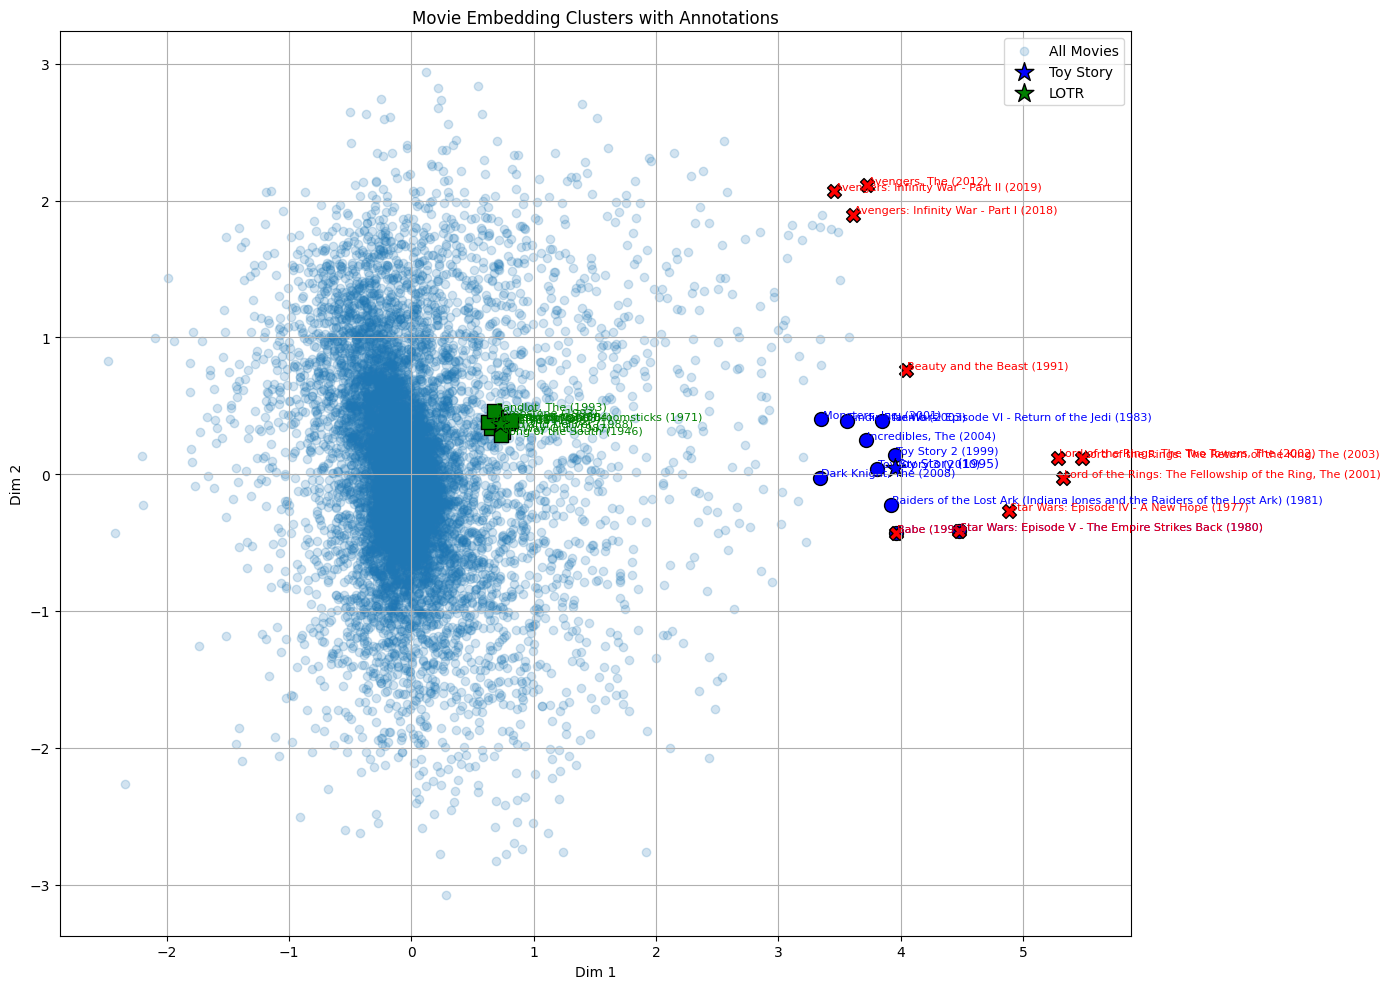

In [47]:
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import numpy as np

movie_embeddings = embeddings[1]

toy_story_idx = movie_to_idx[movie_name_to_movie_id["Toy Story (1995)"]]
lotr_idx = movie_to_idx[movie_name_to_movie_id["Lord of the Rings, The (1978)"]]

# Compute distances
dist_toy_story = euclidean_distances([movie_embeddings[toy_story_idx]], movie_embeddings)[0]
dist_lotr = euclidean_distances([movie_embeddings[lotr_idx]], movie_embeddings)[0]

# Get top N similar movies
N = 10
similar_toy_story_indices = dist_toy_story.argsort()[1:N+1]
similar_lotr_indices = dist_lotr.argsort()[1:N+1]

# Identify "polarising" movies — furthest from the mean
mean_embedding = np.mean(movie_embeddings, axis=0)
dists_to_mean = euclidean_distances([mean_embedding], movie_embeddings)[0]
polarising_indices = dists_to_mean.argsort()[-N:]

# --- Plotting ---
plt.figure(figsize=(14, 10))
plt.scatter(movie_embeddings[:, 0], movie_embeddings[:, 1], alpha=0.2, label="All Movies")

# Function to label movies on plot
def annotate(indices, color, name):
    for idx in indices:
        x, y = movie_embeddings[idx]
        title = movie_id_to_movie_name[idx_to_movie[idx]]  # assumes these are available
        plt.scatter(x, y, color=color, marker=dict(
            Toy="o", LOTR="s", Polar="X")[name], s=100, edgecolor="black", label=None)
        plt.text(x + 0.01, y + 0.01, title, fontsize=8, color=color)

# Group 1: Toy Story cluster
annotate(similar_toy_story_indices, color="blue", name="Toy")
# Group 2: Lord of the Rings cluster
annotate(similar_lotr_indices, color="green", name="LOTR")
print(f"LOTR Similar Movies: {[movie_id_to_movie_name[idx_to_movie[i]] for i in similar_lotr_indices]}")
# Group 3: Polarising Movies
annotate(polarising_indices, color="red", name="Polar")

# Annotate centers
x_toy, y_toy = movie_embeddings[toy_story_idx]
plt.scatter(x_toy, y_toy, color="blue", marker="*", s=200, label="Toy Story", edgecolor="black")
plt.text(x_toy + 0.01, y_toy + 0.01, "Toy Story (1995)", fontsize=9, color="blue")

x_lotr, y_lotr = movie_embeddings[lotr_idx]
plt.scatter(x_lotr, y_lotr, color="green", marker="*", s=200, label="LOTR", edgecolor="black")
plt.text(x_lotr + 0.01, y_lotr + 0.01, "LOTR (1978)", fontsize=9, color="green")

# Finalize
plt.title("Movie Embedding Clusters with Annotations")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(image_path + 'embedding_clusters_labeled.svg')
plt.show()
